In [ ]:
# https://en.wikipedia.org/wiki/Projectile_motion#Trajectory_of_a_projectile_with_Stokes_drag
# https://baseballsavant.mlb.com/statcast_field?ev=104&la=35
# https://www.cpp.edu/~pbsiegel/javascript/statcast.pdf
# https://www.baseballprospectus.com/news/article/52079/statcast-launch-angle-a-statistical-accuracy-assessment/
# https://tht.fangraphs.com/research-notebook-new-format-for-statcast-data-export-at-baseball-savant/

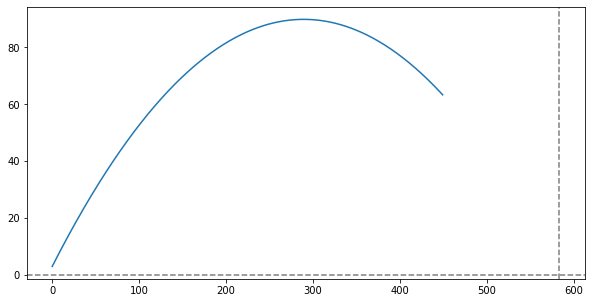

In [1]:
import matplotlib.pyplot as plt
import numpy as np


fig, ax = plt.subplots(figsize=(10, 5))


G = 9.81 * 3.28084


@np.vectorize
def vertical_position(x, θ, h0, v0):
    # return -(G / 2) * np.power(x / (v * np.cos(θ)), 2) + (x * np.sin(θ)) / np.cos(θ) + h0
    a = np.tan(θ)
    b = G / (2 * np.power(v0 * np.cos(θ), 2))
    return a*x - b*np.power(x, 2) + h0

@np.vectorize
def horizontal_distance(θ, h0, v0):
    a = np.tan(θ)
    b = G / (2 * np.power(v0 * np.cos(θ), 2))
    return np.roots([-b, a, h0])[0]


θ = 31
v0 = 99 * 1.46667
h0 = 3.
x = np.arange(450)
ax.plot(x, vertical_position(x, θ * np.pi / 180, h0, v0))
ax.axhline(0, ls='--', color='C7')
ax.axvline(horizontal_distance(θ * np.pi / 180, h0, v0), ls='--', color='C7')

# Simulations

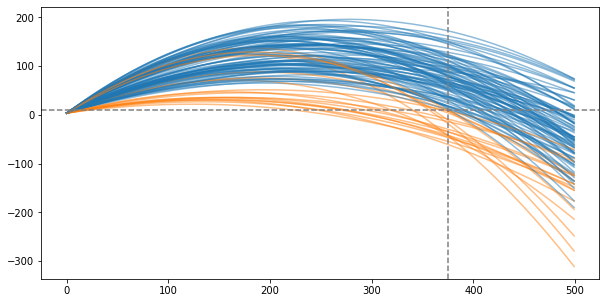

In [2]:
import matplotlib.pyplot as plt
import scipy.stats as ss


fig, ax = plt.subplots(figsize=(10, 5))


N = 100

R = 375.
H = 10.
θ = ss.beta(3, 1).rvs(N)[:, None]
v0 = ss.norm(85, 5).rvs(N)[:, None] * 1.46667
h0 = ss.norm(4, .2).rvs(N)[:, None]
error = np.array([0])[:, None]
x = np.arange(500)[None, :]


distance = horizontal_distance(θ, h0, v0)
y = (
    (distance > R)
    & (vertical_position(R, θ, h0, v0) > H)
).astype(int)

colors = ['C0' if yi else 'C1' for yi in y.ravel()]
for c, v in zip(colors, (vertical_position(x, θ, h0, v0) + error)):
    _ = ax.plot(v, color=c, alpha=.5)    

ax.axhline(H, ls='--', color='C7')
ax.axvline(R, ls='--', color='C7')

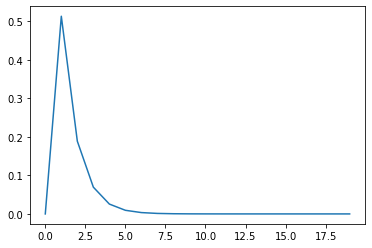

In [69]:
plt.plot(ss.expon(1 / 3).pdf(np.arange(20)))

In [ ]:
import aesara.tensor as at
import pymc as pm


N = 100
R = 375.
H = 10.
θ = ss.beta(3, 1).rvs(N)[:, None]
v0 = ss.norm(85, 5).rvs(N)[:, None] * 1.46667
h0 = ss.norm(4, .2).rvs(N)[:, None]

horizontal_distance(θ, h0, v0)
y = (
    (distance > R)
    & (vertical_position(R, θ, h0, v0) > H)
).astype(int)


def tensor_vertical_position(x, θ, h0, v0):
    a = at.tan(θ)
    b = G / (2 * at.pow(v0 * at.cos(θ), 2))
    return a*x - b*at.pow(x, 2) + h0


with pm.Model() as model:
    radius_mean = pm.Gamma('radius_mean', mu=375, sigma=5)
    radius = pm.Normal('radius', mu=radius_mean, sigma=2)
    height_mean = pm.Gamma('height_mean', mu=5, sigma=2)
    height = pm.Normal('height', mu=height_mean, sigma=1)

    radius_cdf = at.exp(pm.logcdf(radius, distance))
    height_cdf = at.exp(pm.logcdf(height, tensor_vertical_position(radius, θ, h0, v0)))
    p = pm.Deterministic('p', at.clip(radius_cdf * height_cdf, 1e-2, 1 - 1e-2))

    likelihood = pm.Bernoulli('likelihood', p=p, observed=y)
    idata = pm.sample(4000, tune=3000)

/Users/dantegates/virtualenvs/v3.8/lib/python3.8/site-packages/pymc/aesaraf.py:1005: UserWarning: The parameter 'updates' of aesara.function() expects an OrderedDict, got <class 'dict'>. Using a standard dictionary here results in non-deterministic behavior. You should use an OrderedDict if you are using Python 2.7 (collections.OrderedDict for older python), or use a list of (shared, update) pairs. Do not just convert your dictionary to this type before the call as the conversion will still be non-deterministic.
  aesara_function = aesara.function(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [radius_mean, radius, height_mean, height]


In [ ]:
with model:
    priors = pm.sample_prior_predictive(var_names=[
        'likelihood',
        # 'radius',
        # 'height',
        # 'radius_cdf',
    ])

In [ ]:
plt.hist(priors.prior_predictive.likelihood.mean(axis=(0, 1)))

In [ ]:
import arviz as az

az.plot_trace(idata, var_names=['~error'])
plt.tight_layout()

In [ ]:
plt.hist(idata.posterior.p.mean(axis=(0, 1)))

# Actuals

In [ ]:
import pandas as pd

df = pd.read_csv('statcast-2022-05-20.csv.gz')
df.shape

In [ ]:
df.launch_speed_angle.max() * 60

In [ ]:
s[['hc_x', 'hc_y']].max()

In [ ]:
import matplotlib.pyplot as plt


features = [
    'hc_x',
    'hc_y',
    'hit_distance_sc',
    'launch_speed_angle',
    'launch_speed'
]


s = df[df.events.eq('home_run')][features].sample(10000).dropna()
plt.scatter(s.hc_x, s.hc_y)

In [ ]:
fig, ax = plt.subplots(subplot_kw={'projection': 'polar'})

ax.scatter(np.arctan(s.hc_y / s.hc_x), s.hit_distance_sc)

In [ ]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(10, 5), subplot_kw={'projection': 'polar'})



axs[0].scatter(np.arctan(s.hc_y / s.hc_x), s.hit_distance_sc)
axs[1].scatter(np.arctan(s.hc_y / s.hc_x), distance(s.launch_speed_angle * np.pi / 180, 3., s.launch_speed))